## Clustering Analysis
### Maching Learning Foundations with Python - SP23
#### Team Name: Team 8 (Grace Eunji Kim, Sajujya Gangopadhyay, Yi-Hsueh Yang)

Here, our goal is to look at the movie data and run an unsupervised algorithm that will cluster the movies based on the different numerical features. This will help the management decide which types of movies are the best and worst performing ones. 

Additionally, it will also help us look at the various features of these high and low performing movies so that Netflix can decide on which movies to add or remove from its collection. 

## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs
import copy
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering


%matplotlib inline

## Reading the Data

In [2]:
movie_data = pd.read_csv("final_netflix_dataset.csv", low_memory=False, index_col=0)
movie_data.head()

,Year,Cust_Id,User Rating,Title,IMDb Rating,Runtime (IMDb),Genres (IMDb),Num Votes (IMDb),Country,MPA Rating,Runtime (Netflix),Listed_in,Description
0,2003,2173336,5.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."
1,2003,2473170,5.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."
2,2003,900816,3.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."
3,2003,1990901,4.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."
4,2003,662337,4.0,Something's Gotta Give,6.7,128.0,"Comedy, Drama, Romance",124315.0,United States,PG-13,128 min,"Comedies, Romantic Movies","Still sexy at 60, Harry Sanborn wines and dine..."


#### Data Cleaning


We clean the Final Netflix Movie dataset to specifically create a dataframe which feeds the purpose of the unsupervised learning. First, let us look at the total number of rows, columns, and some summary statistics. 

In [3]:
#looking at the shape of our dataset
movie_data.shape

(6356792, 13)

In [4]:
#checking the columns we have
movie_data.columns

Index(['Year', 'Cust_Id', 'User Rating', 'Title', 'IMDb Rating',
       'Runtime (IMDb)', 'Genres (IMDb)', 'Num Votes (IMDb)', 'Country',
       'MPA Rating', 'Runtime (Netflix)', 'Listed_in', 'Description'],
      dtype='object')

In [5]:
#Let us now check how many movies we have
movie_data.Title.nunique()

226

In [6]:
#looking at the percentage of null values in our dataset
movie_data.isnull().sum() / len(movie_data) * 100

Year                 0.000000
Cust_Id              0.000000
User Rating          0.000000
Title                0.000000
IMDb Rating          0.000000
Runtime (IMDb)       0.001196
Genres (IMDb)        0.000000
Num Votes (IMDb)     0.000000
Country              1.105652
MPA Rating           0.000000
Runtime (Netflix)    0.000000
Listed_in            0.000000
Description          0.000000
dtype: float64

#### Here, we create one a new dataframe, which contains each unique movie - which would contain the average user rating in the "User Rating" column for each of the movie. 

In [7]:
#Now let us create a new dataframe which has the Mean User Rating for each Movie Title in a separate column
clustering_df = copy.deepcopy(movie_data)
df_with_avg_ratings = clustering_df[["Title", "IMDb Rating", "User Rating", "Runtime (IMDb)", "Num Votes (IMDb)", "Year"]].groupby(by = "Title", as_index = False).mean()
df_with_avg_ratings.rename(columns = {"User Rating" : "Average User Rating"}, inplace = True)

#converting the year column to int datatype
df_with_avg_ratings["Year"] = df_with_avg_ratings["Year"].astype(int)
df_with_avg_ratings

,Title,IMDb Rating,Average User Rating,Runtime (IMDb),Num Votes (IMDb),Year
0,A Family Affair,7.1,2.610817,110.0,638.0,2003
1,A Night at the Roxbury,6.2,3.137460,82.0,62081.0,1998
2,A Wrinkle in Time,4.2,3.375224,109.0,46021.0,2003
3,Aitraaz,6.6,3.329787,160.0,10551.0,2004
4,Alive and Kicking,6.5,3.044025,94.0,329.0,1996
...,...,...,...,...,...,...
221,U Turn,7.4,3.104744,120.0,3639.0,1997
222,What Lies Beneath,6.6,3.512766,130.0,129615.0,2000
223,Wild Wild West,4.9,2.855980,106.0,163212.0,1999
224,Willy Wonka & the Chocolate Factory,7.8,4.074219,100.0,207212.0,1971


## Initial Data Visualizations

Here, we do some initial data visualization to understand the the variation between features.

### Visualization 1 - Correlation Plot 

Let's create a correlation plot between the Numerical Features to understand if there is an inherent relationship that the unsupervised learning algorithm can feed off of. 

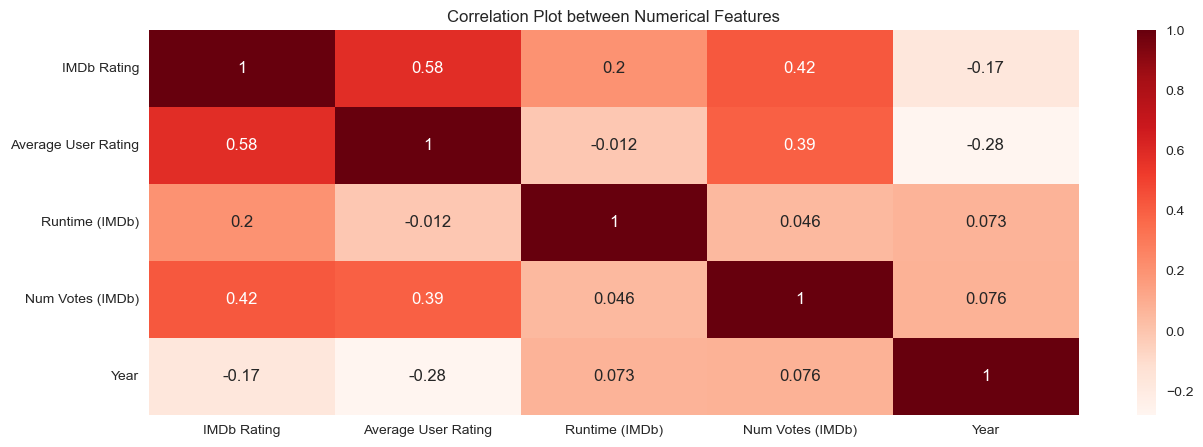

In [8]:
#Creating a correlation matrix plot for the numerical variables
plt.figure(figsize = (15, 5))
plt.title("Correlation Plot between Numerical Features")
sns.heatmap(df_with_avg_ratings.corr(), annot = True, cmap = "Reds")
plt.show()

### Findings and Explanations

(1) We can see that "IMDb Rating", and "Number of Votes" are positively correlated with the "Average User Rating"

(2) We can see that "Runtime", and "Year" are slightly negatively correlated with the "6Average User Rating"

(3) Additionally, we see that "Year" has a positive correlation with the "Runtime", which signifies that older movies in our dataset are usually the longer ones. 

Therefore, there are significant relationships between the features. This means that we can actually create clusters that can feed off of the correlation among the features. 


In [9]:
#checking for nulls
df_with_avg_ratings.isnull().sum()

Title                  0
IMDb Rating            0
Average User Rating    0
Runtime (IMDb)         1
Num Votes (IMDb)       0
Year                   0
dtype: int64

In [10]:
#deleting the movie with the null runtime since unsupervised learning algorithms like KMeans cannot work with NaN values
df_with_avg_ratings.dropna(inplace = True)

#checking to see if we still have any null values
df_with_avg_ratings.isnull().sum()

Title                  0
IMDb Rating            0
Average User Rating    0
Runtime (IMDb)         0
Num Votes (IMDb)       0
Year                   0
dtype: int64

Since we have only 1 movie with a Null "Runtime" feature, we can afford to delete this entry. We don't do imputation since it does not make sense to impute Runtime of any movie with the mean/median/mode values. 

## Summary Statistics 

In [11]:
# Drop the title column because we are not using it as a feature
X = df_with_avg_ratings.drop(columns = ["Title"])
X.describe()

,IMDb Rating,Average User Rating,Runtime (IMDb),Num Votes (IMDb),Year
count,225.000000,225.000000,225.000000,2.250000e+02,225.000000
mean,6.507778,3.362830,115.026667,1.274553e+05,1994.800000
std,1.068291,0.432594,29.117859,2.263883e+05,10.757472
min,2.300000,1.790850,30.000000,8.100000e+01,1924.000000
25%,5.900000,3.097561,94.000000,6.619000e+03,1991.000000
50%,6.600000,3.428435,111.000000,3.847550e+04,1998.000000
75%,7.300000,3.655739,130.000000,1.632120e+05,2002.000000
max,8.700000,4.333190,238.000000,1.939078e+06,2005.000000


## Scaling the features

In [12]:
# Use StandardScaler to scale the features so that they are on the same scale
features = X.columns
X[features] = StandardScaler().fit_transform(X[features])
X.describe()

,IMDb Rating,Average User Rating,Runtime (IMDb),Num Votes (IMDb),Year
count,2.250000e+02,2.250000e+02,2.250000e+02,2.250000e+02,2.250000e+02
mean,-3.473764e-16,2.376494e-16,-1.746751e-16,1.973730e-17,4.237598e-15
std,1.002230e+00,1.002230e+00,1.002230e+00,1.002230e+00,1.002230e+00
min,-3.947577e+00,-3.641952e+00,-2.926597e+00,-5.638908e-01,-6.596146e+00
25%,-5.701940e-01,-6.145728e-01,-7.237328e-01,-5.349468e-01,-3.540304e-01
50%,8.651938e-02,1.519929e-01,-1.385969e-01,-3.939168e-01,2.981309e-01
75%,7.432327e-01,6.786098e-01,5.153785e-01,1.582965e-01,6.707945e-01
max,2.056659e+00,2.248124e+00,4.232712e+00,8.020124e+00,9.502922e-01


# Modeling

For our models, we will explore 2 specific unsupervised learning algorithms:

(1) KMeans Clustering 

(2) Agglomerative Clustering (Hierarchical) 


Our goal is to finally look at the the distribution of the features across the different clusters to try to glean any additional information from them. 

## Model 1 - K-Means Clustering 

In [13]:
#creating an instance of the KMeans model
model = KMeans(random_state = 1, n_init="auto")

#fitting the model to the data
model.fit(X)

KMeans(n_init='auto', random_state=1)

Now that we have created our KMeans object, let us find the best "k", i.e., the best Number of clusters.

We aim to do this using three different metrics. 

(1) Elbow Score 

(2) Calinski Harabasz Score 

(3) Silhouette Score 

We know that the Elbow score is usually the weakest metric among the three. Therefore, we will possibly taking a margin call on the number of clusters to have at the end using a combination of the Calinski Harabasz and the Silhouette Scores and a judgement call (if necessary). 

### Finding the best  K for our KMeans Model

#### Tuning Using the Elbow Score

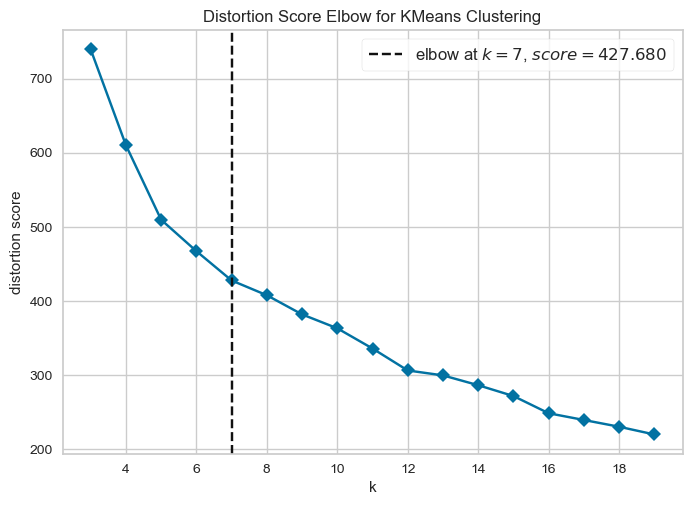

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
#using the Elbow Score Method
visualizer = KElbowVisualizer(model, k = (3, 20), timings=False)
visualizer.fit(X)
visualizer.show()

According to the Elbow score method, the best number of clusters is k = 7, which generates an elbow score of around 427. 

#### Tuning using the Calinkski - Harabasz score

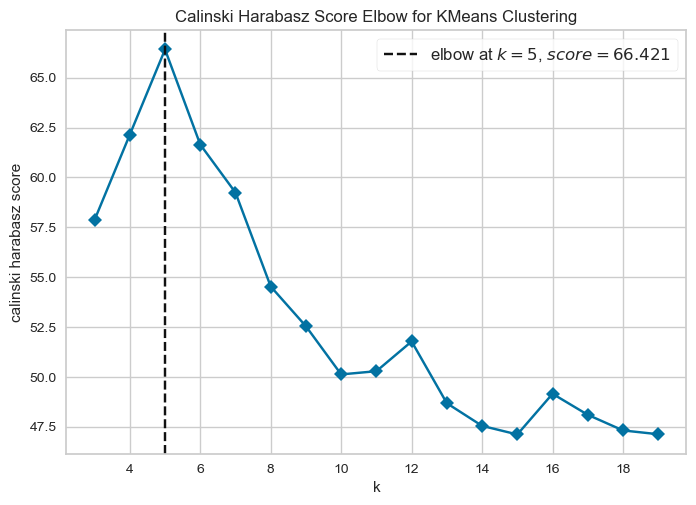

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [15]:
# using the Calinski Harabasz score to calculate the number of clusters
visualizer = KElbowVisualizer(model, k = (3, 20), timings=False, locate_elbow=True, metric = "calinski_harabasz")
visualizer.fit(X)
visualizer.show()

According to the Calinski Harabasz method, best number of clusters is k = 5. 

#### Tuning using the Silhouette Metric

In [16]:
#checking for the K using the Silhouette Score Metric
scores = []
for i in range(3, 20):
    #Instantiate the KMeans models
    km = KMeans(n_clusters=i, random_state=42, n_init = "auto")
    # Fit the KMeans model
    km.fit_predict(X)
    # Calculate Silhoutte Score
    score = silhouette_score(X, km.labels_, metric='euclidean')
    scores.append(score)

#creating a dataframe for storing the Number of Clusters and corresponding Silhouette Score
scores_df = pd.DataFrame({"Number of Clusters" : [], "Silhouette Score" : []})
for i in range(3, 20):
    scores_df.loc[len(scores_df.index)] = [i, scores[i-3]]
    

#priting the Silhouette Score Dataframe
scores_df

,Number of Clusters,Silhouette Score
0,3.0,0.224692
1,4.0,0.227411
2,5.0,0.220210
3,6.0,0.208550
4,7.0,0.207838
5,8.0,0.222550
6,9.0,0.222216
7,10.0,0.198524
8,11.0,0.200724
9,12.0,0.203677


Now, we know that Silhouette Scores have a range of [-1, 1]. The closer the score is to 1, the better our unsupervised model is. 

This is because higher Silhouette Scores correpond to tight, separated clusters. So, from the above dataframe, we understand that 4 clusters generates the highest possible Silhouette Score (0.227). Also, it would definitely make sense to choose the number of clusters as 4, since we could then classify them as: 

(1) Highest Priority 

(2) High Mid 

(3) Low Mid 

(4) Lowest Priority 

#### Using the Silhouette Plots for better understanding the efficiency of each K Value

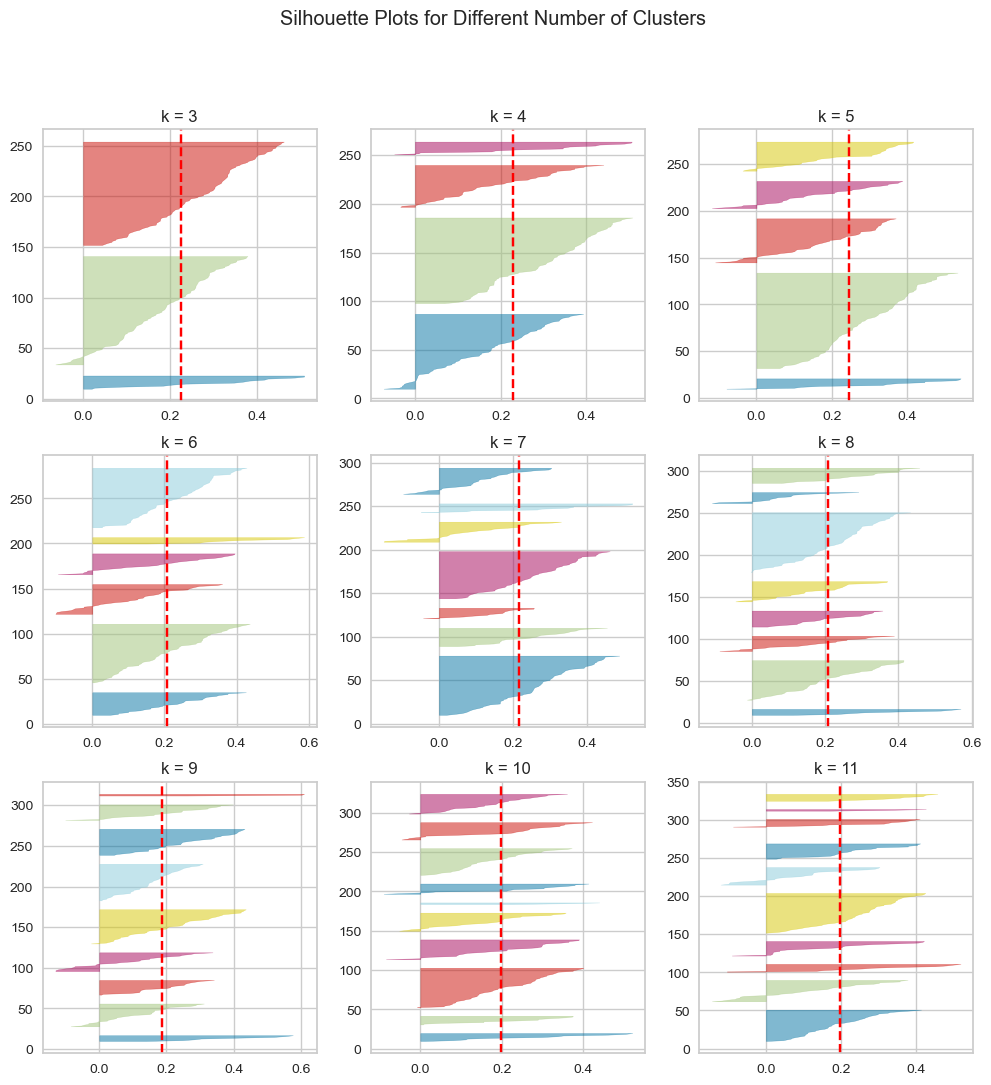

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
fig.suptitle("Silhouette Plots for Different Number of Clusters")

for i, ax in enumerate(axs.flatten()):
    if i < 9:
        k = i + 3
        kmeans_for_silhoutte = KMeans(n_clusters=k, n_init= "auto") 
        visualizer = SilhouetteVisualizer(kmeans_for_silhoutte, colors='yellowbrick', ax=ax)
        visualizer.fit(X)
        visualizer.set_title('k = {}'.format(k)) 

So, from here, we understand that k = 4 is our best shot at the number of clusters. This is because for 4 clusters: 

(1) The least number of movies are being assigned to the wrong cluster (signified by the negative coefficient values in the plots) 


(2) The clusters are evenly split in size 


(3) Thickness of each of the clusters is comparatively more uniform than the other plots with different number of clusters. 


##### Therefore, for our final KMeans model, we will choose k = 4. 

### Training our Final K-Means Model

In [18]:
#creating the final KMeans Model object
final_model = KMeans(n_clusters=4, random_state=1, n_init="auto")

#creating a deepcopy to have a backup 
X_with_predicted_labels = copy.deepcopy(df_with_avg_ratings)

#fitting the model to the data
final_model.fit(X)

#predicting the labels
X_with_predicted_labels["K Means Cluster Labels"] = final_model.labels_

#printing the combined dataframe
X_with_predicted_labels.head()


,Title,IMDb Rating,Average User Rating,Runtime (IMDb),Num Votes (IMDb),Year,K Means Cluster Labels
0,A Family Affair,7.1,2.610817,110.0,638.0,2003,3
1,A Night at the Roxbury,6.2,3.137460,82.0,62081.0,1998,3
2,A Wrinkle in Time,4.2,3.375224,109.0,46021.0,2003,3
3,Aitraaz,6.6,3.329787,160.0,10551.0,2004,2
4,Alive and Kicking,6.5,3.044025,94.0,329.0,1996,3


### Looking at the distributions of different variables across the clusters

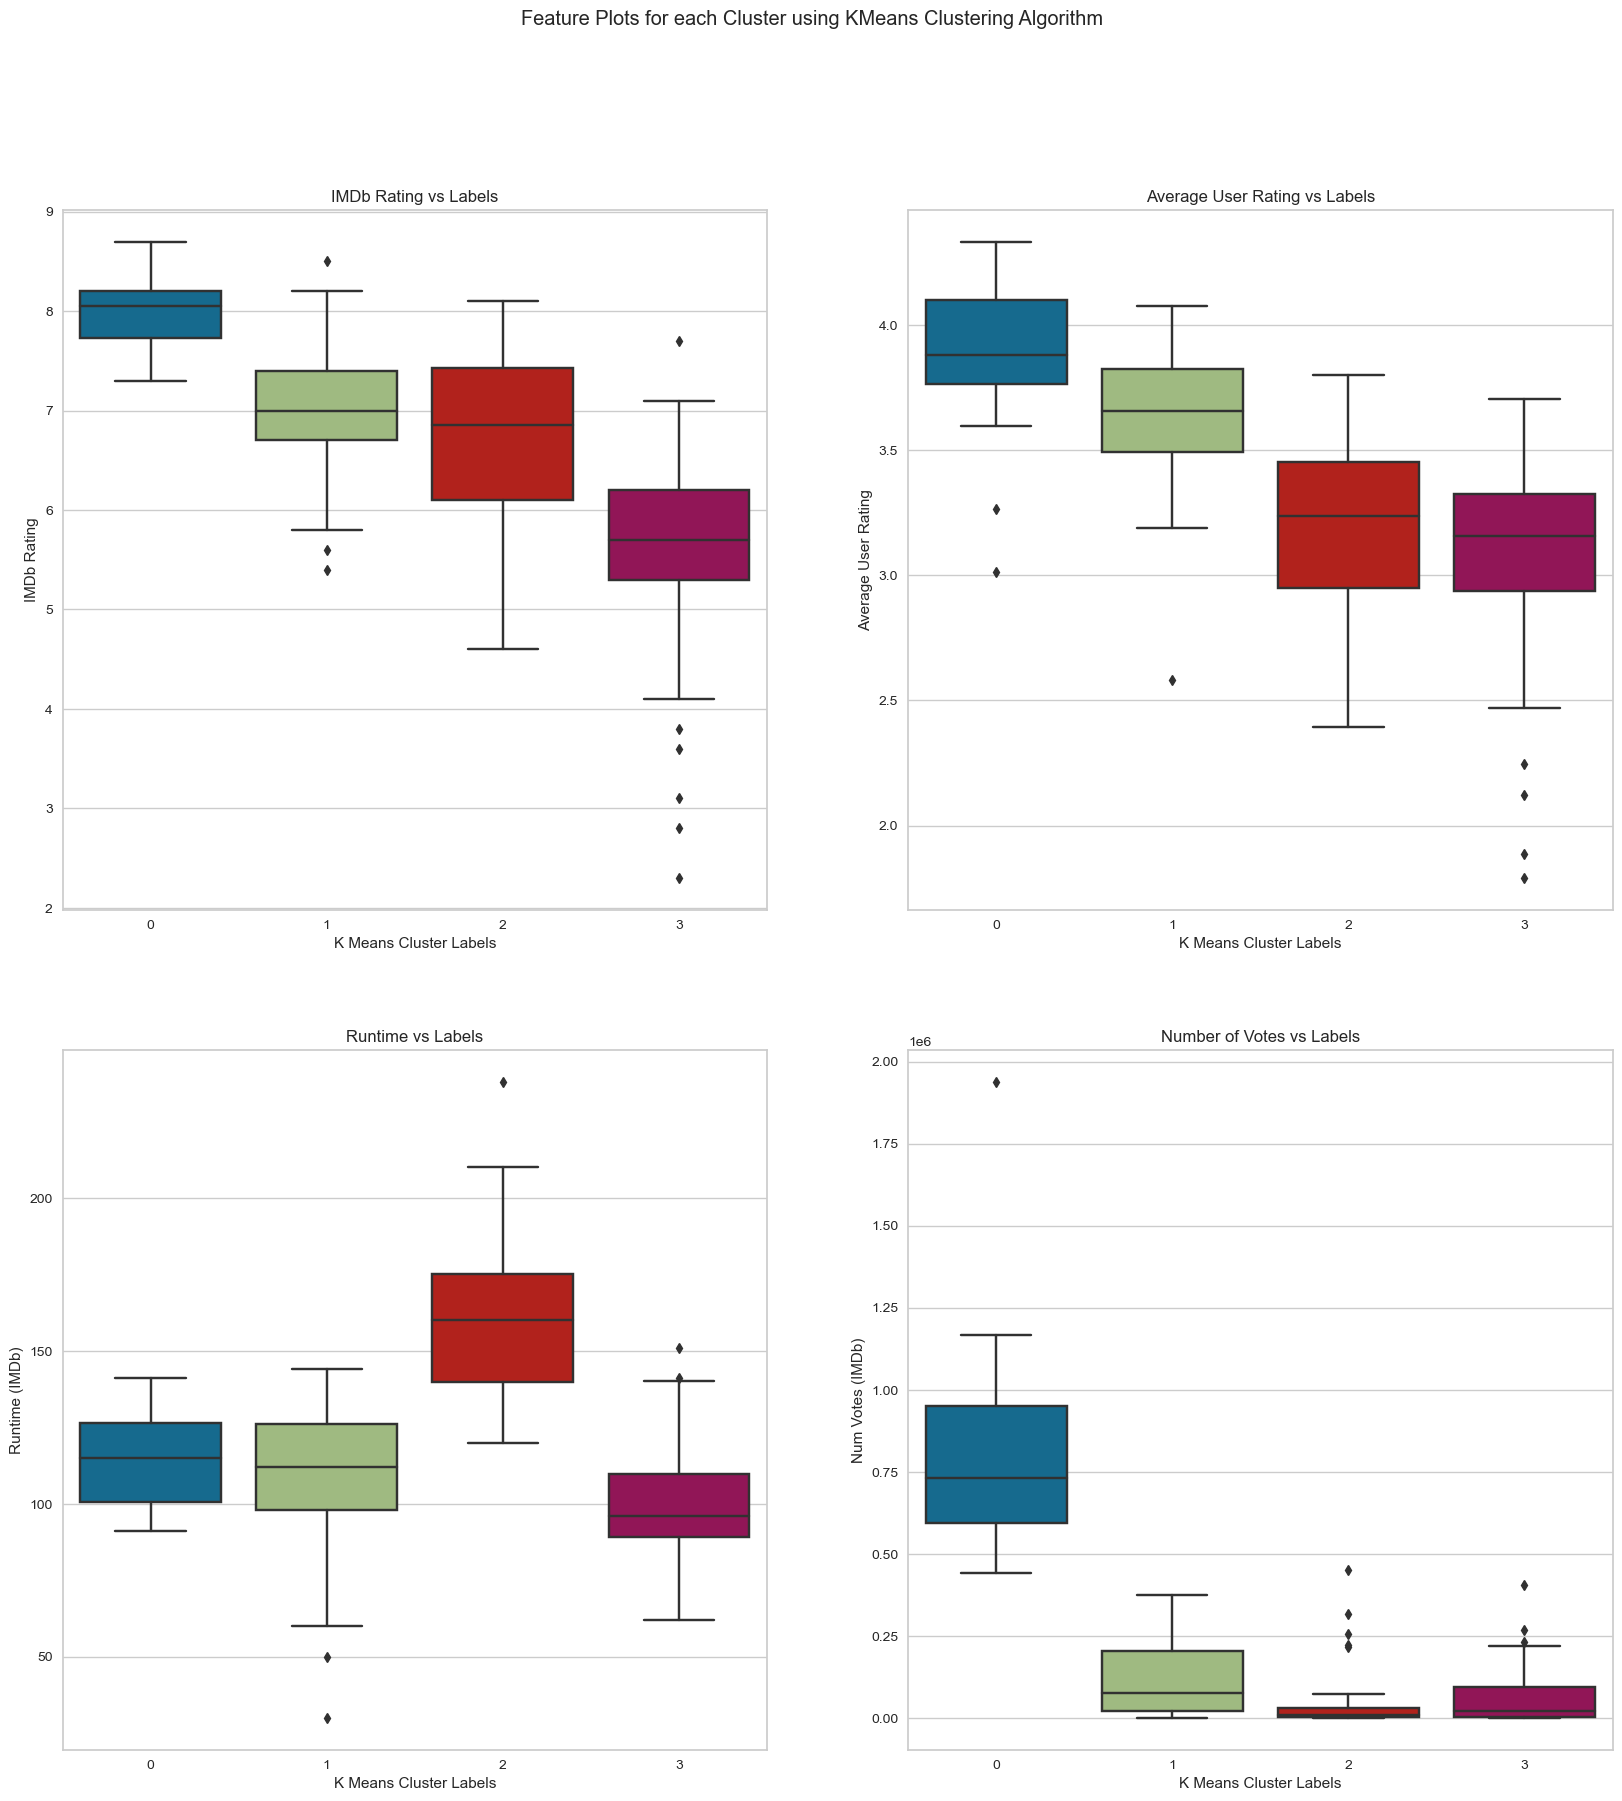

In [19]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

fig.suptitle('Feature Plots for each Cluster using KMeans Clustering Algorithm')

sns.boxplot(ax = axes[0, 0], data = X_with_predicted_labels, x = X_with_predicted_labels["K Means Cluster Labels"], 
            y = X_with_predicted_labels["IMDb Rating"])
axes[0, 0].set_title("IMDb Rating vs Labels")


sns.boxplot(ax = axes[0, 1], data = X_with_predicted_labels, x = X_with_predicted_labels["K Means Cluster Labels"], 
            y = X_with_predicted_labels["Average User Rating"])
axes[0, 1].set_title("Average User Rating vs Labels")


sns.boxplot(ax = axes[1, 0], data = X_with_predicted_labels, x = X_with_predicted_labels["K Means Cluster Labels"], 
            y = X_with_predicted_labels["Runtime (IMDb)"])
axes[1, 0].set_title("Runtime vs Labels")


sns.boxplot(ax = axes[1, 1], data = X_with_predicted_labels, x = X_with_predicted_labels["K Means Cluster Labels"], 
            y = X_with_predicted_labels["Num Votes (IMDb)"])
axes[1, 1].set_title("Number of Votes vs Labels")


plt.show()

### Findings and Explanations

(1) So, we see that Cluster 0 is the "Highest Priority" cluster in terms of the fact that it generates the Highest Average User Rating. Additionally, we can see that these movies correspond to:


        (a) High IMDb Rating with a Median IMDb of a little above 8 
        (b) Low Runtime with a Median Runtime of around 120 minutes 
        (c) Very high number of votes with a Median of about 750,000
        
        
Now, we move into Agglomerative Clustering. 

## Model 2 - Hierarchical Clustering

We use Agglomerative Hierarchical clustering because 

(a) We do not have an idea about any pre-existing pattern in the data, which is why use Agglomerative Hierarchical clustering. 

(b) Agglomerative Clustering helps us visualize our cluster splits using a dendrogram. 

We use 4 linkage patterns to see which one performs the best and then train our final model and visualize the clustering using a dendrogram. 

### 2a - Ward Linkage

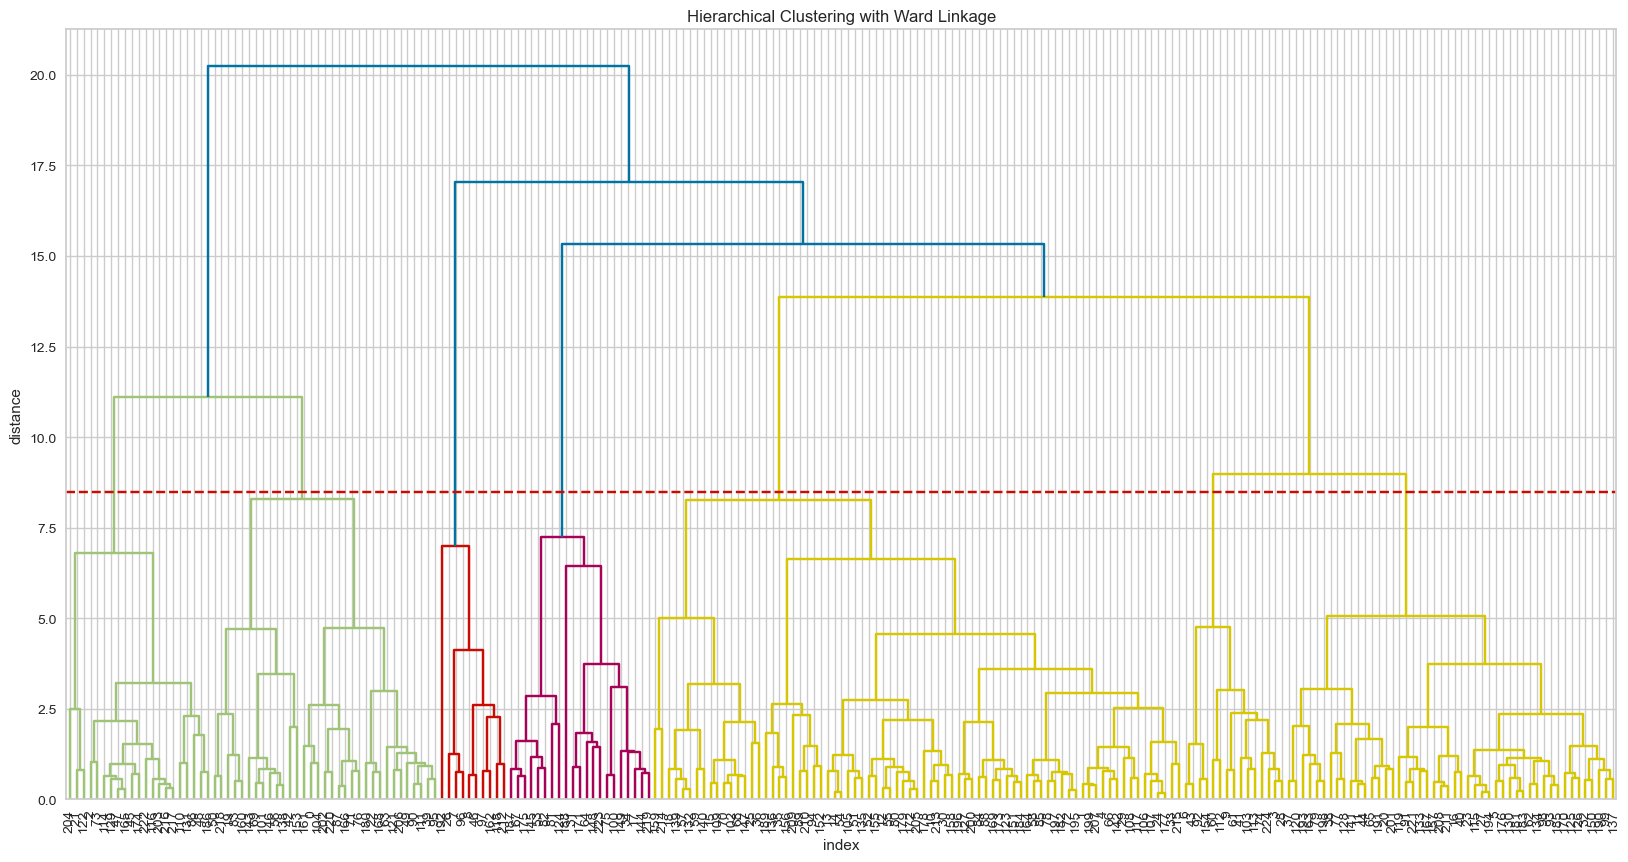

In [20]:
avg1 = shc.linkage(X, "ward")
plt.figure(figsize=(20,10))
plt.grid(visible=True)
plt.title("Hierarchical Clustering with Ward Linkage")
plt.xlabel("index")
plt.ylabel("distance")
shc.dendrogram(avg1, leaf_font_size = 10);
plt.axhline(y = 8.5, color = 'r', linestyle = '--')

7 clusters for Agglomerative Clustering with Ward Linkage. Additionally, at the cutoff, we have evenly split data points. 

### 2b - Single Linkage

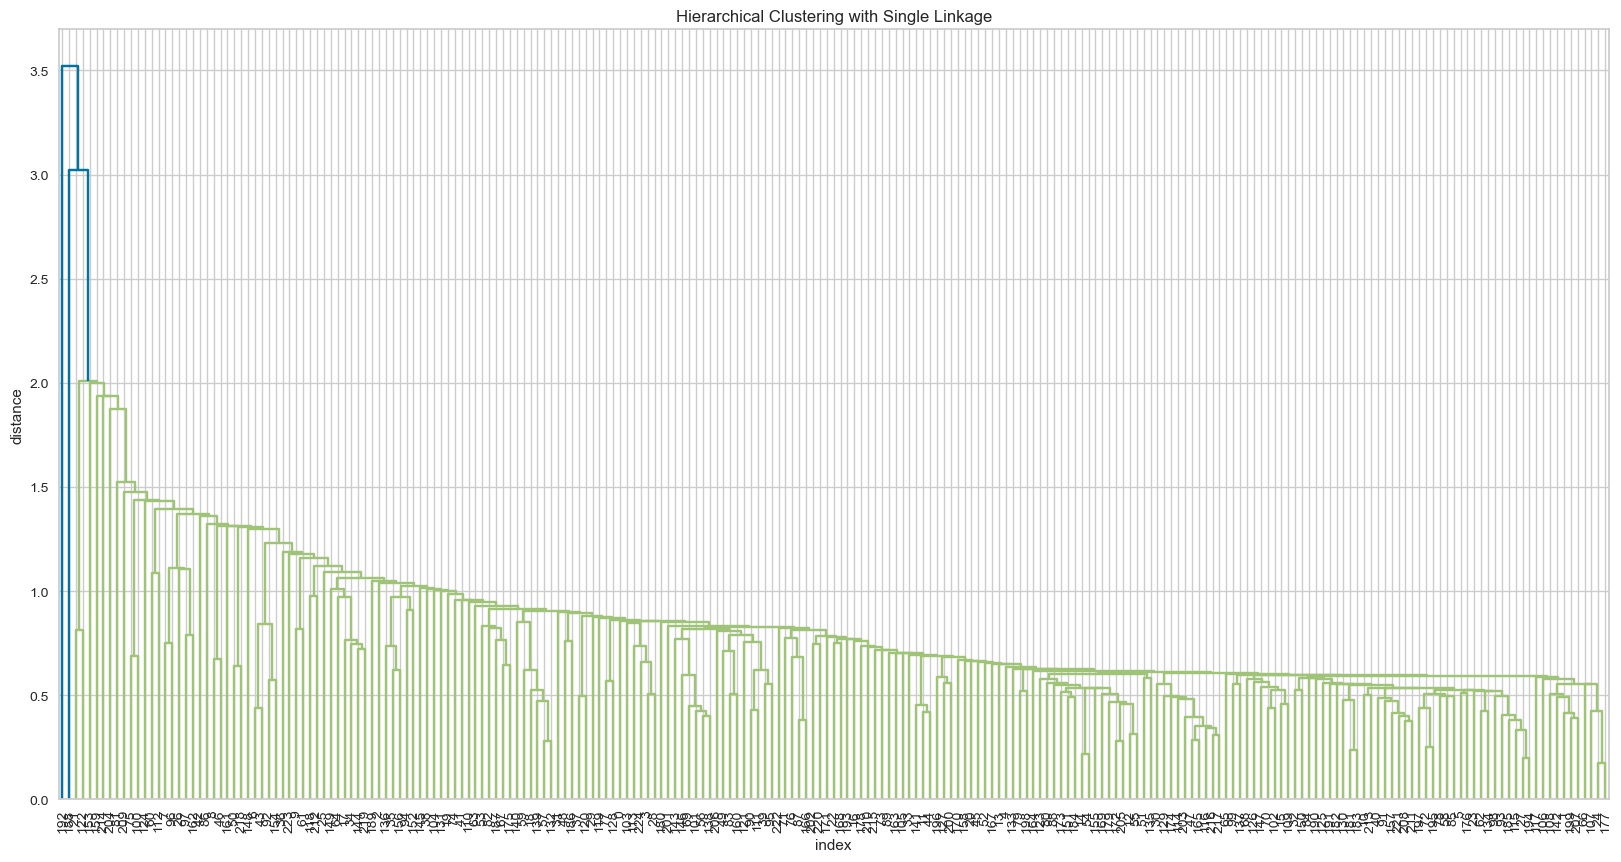

In [21]:
avg1 = shc.linkage(X, "single")
plt.figure(figsize=(20,10))
plt.grid(visible=True)
plt.title("Hierarchical Clustering with Single Linkage")
plt.xlabel("index")
plt.ylabel("distance")
shc.dendrogram(avg1, leaf_font_size = 10);
plt.axhline(y = 9, color = 'r', linestyle = '--')

The Single linkage performs horribly because we see that the dendrogram skews early on. Therefore, this cannot be our best linkage. 

### 2c - Complete Linkage

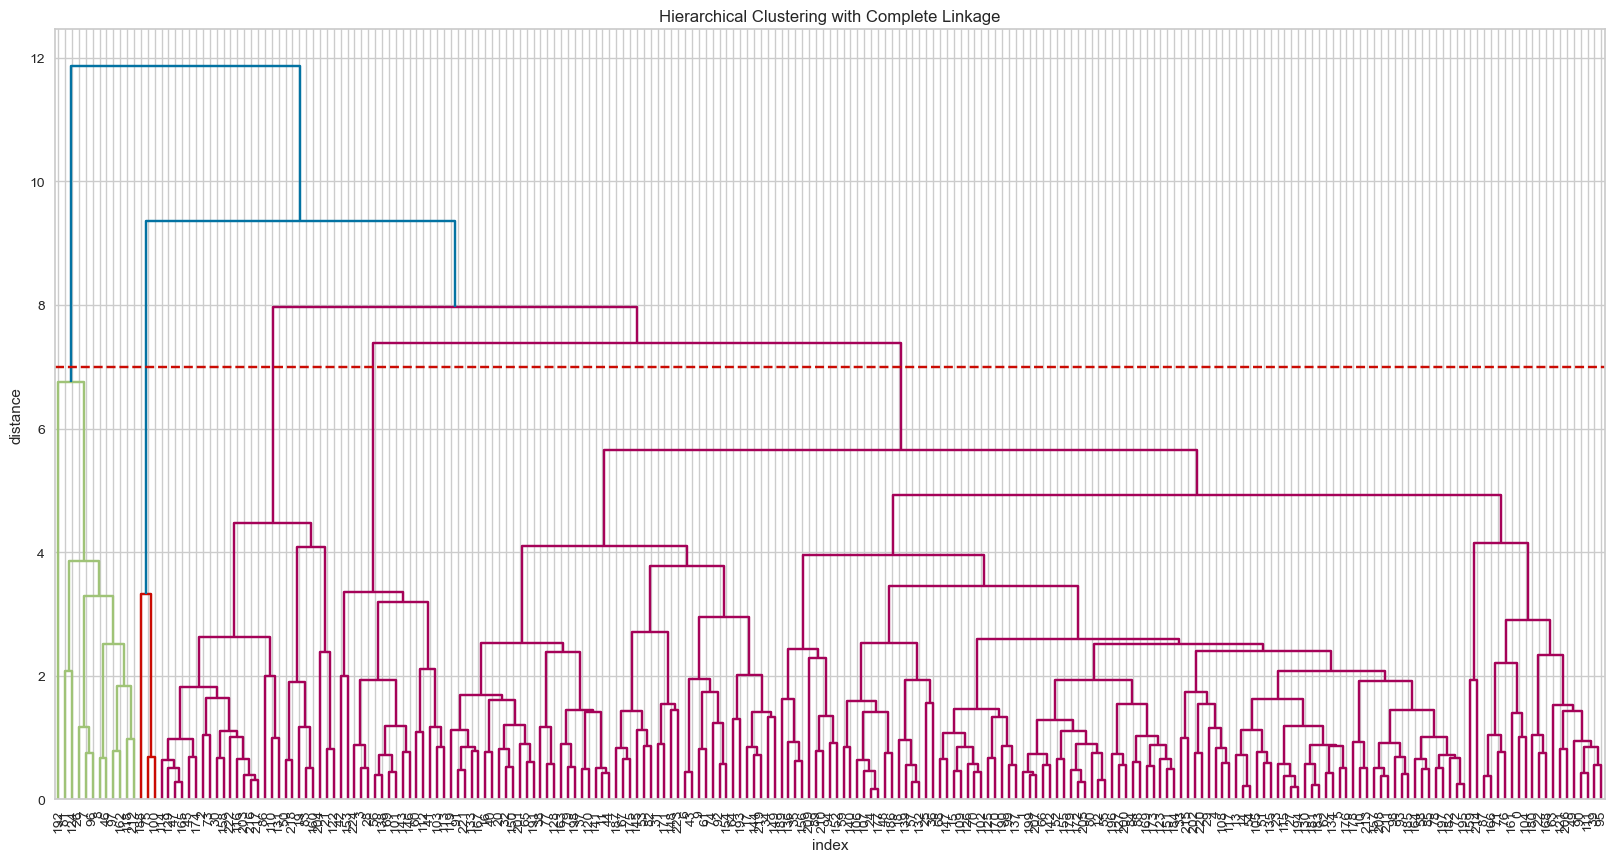

In [22]:
avg1 = shc.linkage(X, "complete")
plt.figure(figsize=(20,10))
plt.grid(visible=True)
plt.title("Hierarchical Clustering with Complete Linkage")
plt.xlabel("index")
plt.ylabel("distance")
shc.dendrogram(avg1, leaf_font_size = 10);
plt.axhline(y = 7, color = 'r', linestyle = '--')

Complete linkage performs better than Single Linkage, but worse than Ward linkage.

Additionally, at the cutoff, the  Complete linkage generates 5 clusters. 

### 2d - Average Linkage

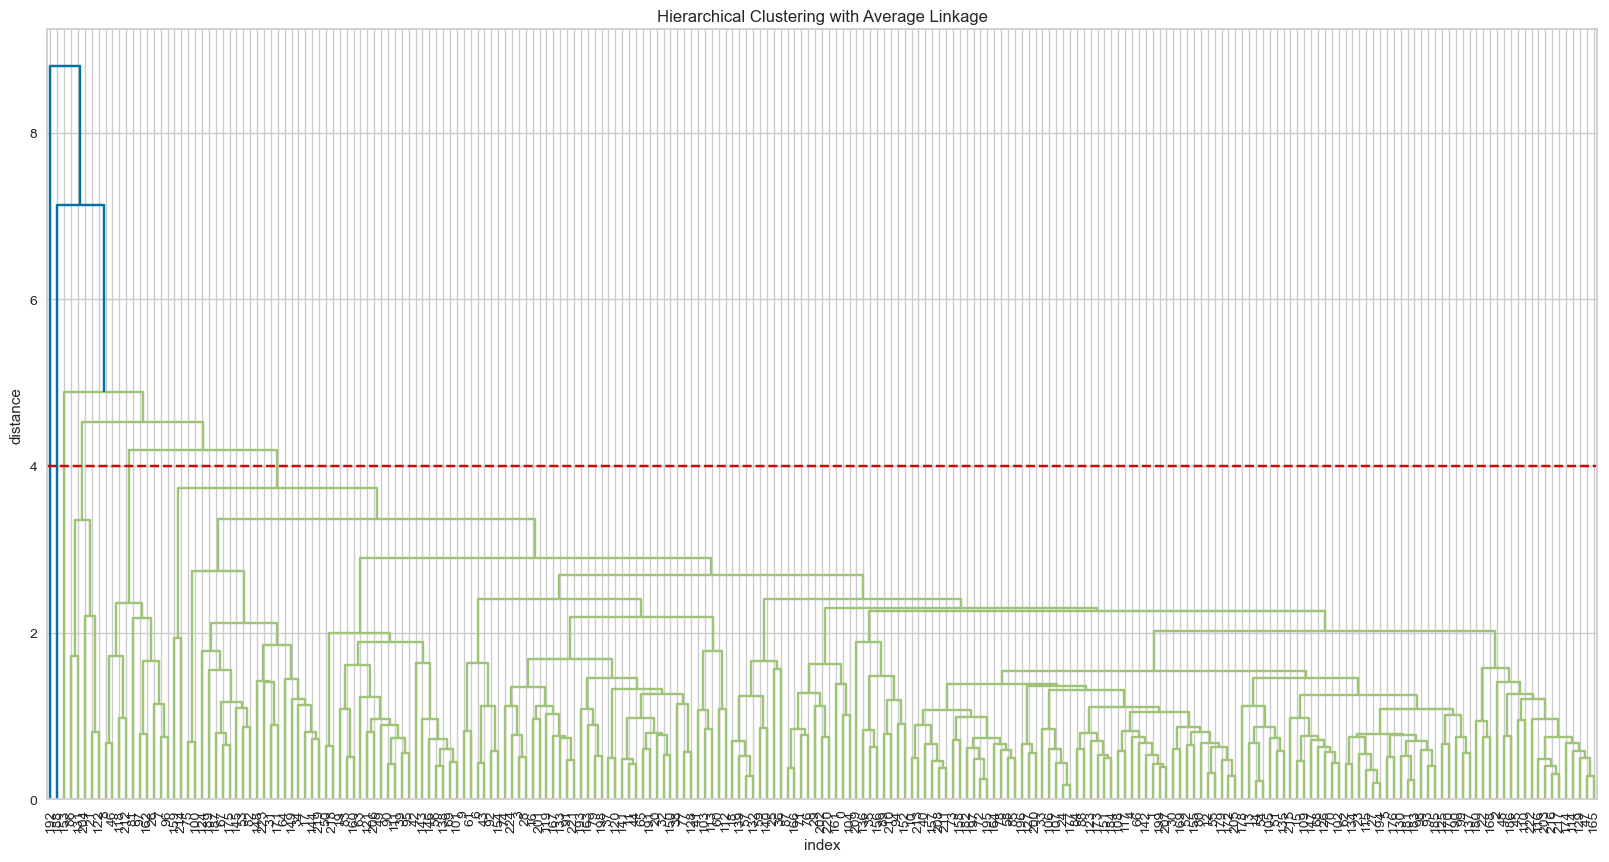

In [23]:
avg1 = shc.linkage(X, "average")
plt.figure(figsize=(20,10))
plt.grid(visible=True)
plt.title("Hierarchical Clustering with Average Linkage")
plt.xlabel("index")
plt.ylabel("distance")
shc.dendrogram(avg1, leaf_font_size = 10);
plt.axhline(y = 4, color = 'r', linestyle = '--')

So, the Average linkage performs equally as worse as the Single linkage. 

#### So, Ward Linkage is our best Hierarchical Clustering Model. 

#### Redrawing the Hierarchical Clustering Dendrogram with Ward Linkage with truncation 

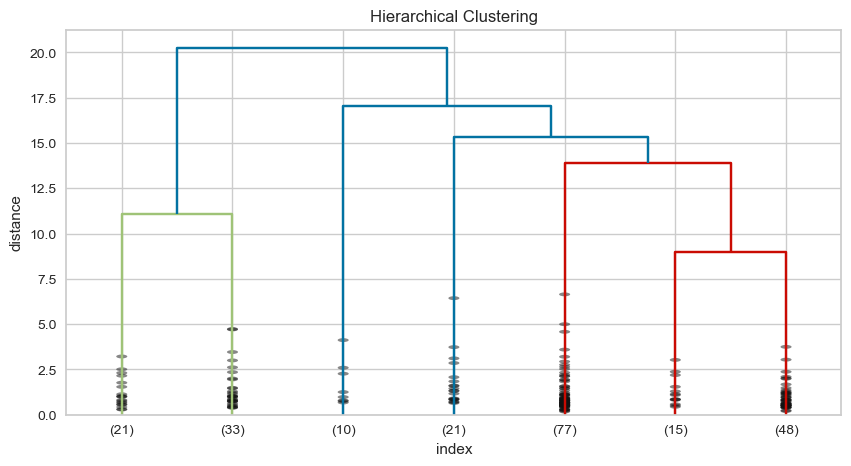

In [24]:
avg1 = shc.linkage(X, "ward")
plt.figure(figsize=(10,5))
plt.grid(visible=True)
plt.title("Hierarchical Clustering")
plt.xlabel("index")
plt.ylabel("distance")
shc.dendrogram(avg1, leaf_font_size = 10, truncate_mode = 'lastp', p = 7, show_contracted=True);

From the dendrogram, we can understand that 

(1) There is an even split among the data points at the cutoff and the linkage type used (Ward) 

Let us now plot the distribution of the features for each of the clusters to get a better understanding of how the features are distributed. Here, we use 7 clusters since that is what is generated at our cutoff. 

In [25]:
#creating the final agglomerative model 
hc_with_7 = AgglomerativeClustering(linkage = "ward", metric= "euclidean", n_clusters = 5)

#fitting it to the data
hc_with_7.fit(X)

#predicting the class labels
Agglometrative_Clustering_with_7_clusters = hc_with_7.labels_

#adding the predicted labels to the dataset
X_with_predicted_labels["Agglometrative Hierarchical Clustering Labels"] = Agglometrative_Clustering_with_7_clusters

### Looking at the distributions of different variables across the clusters

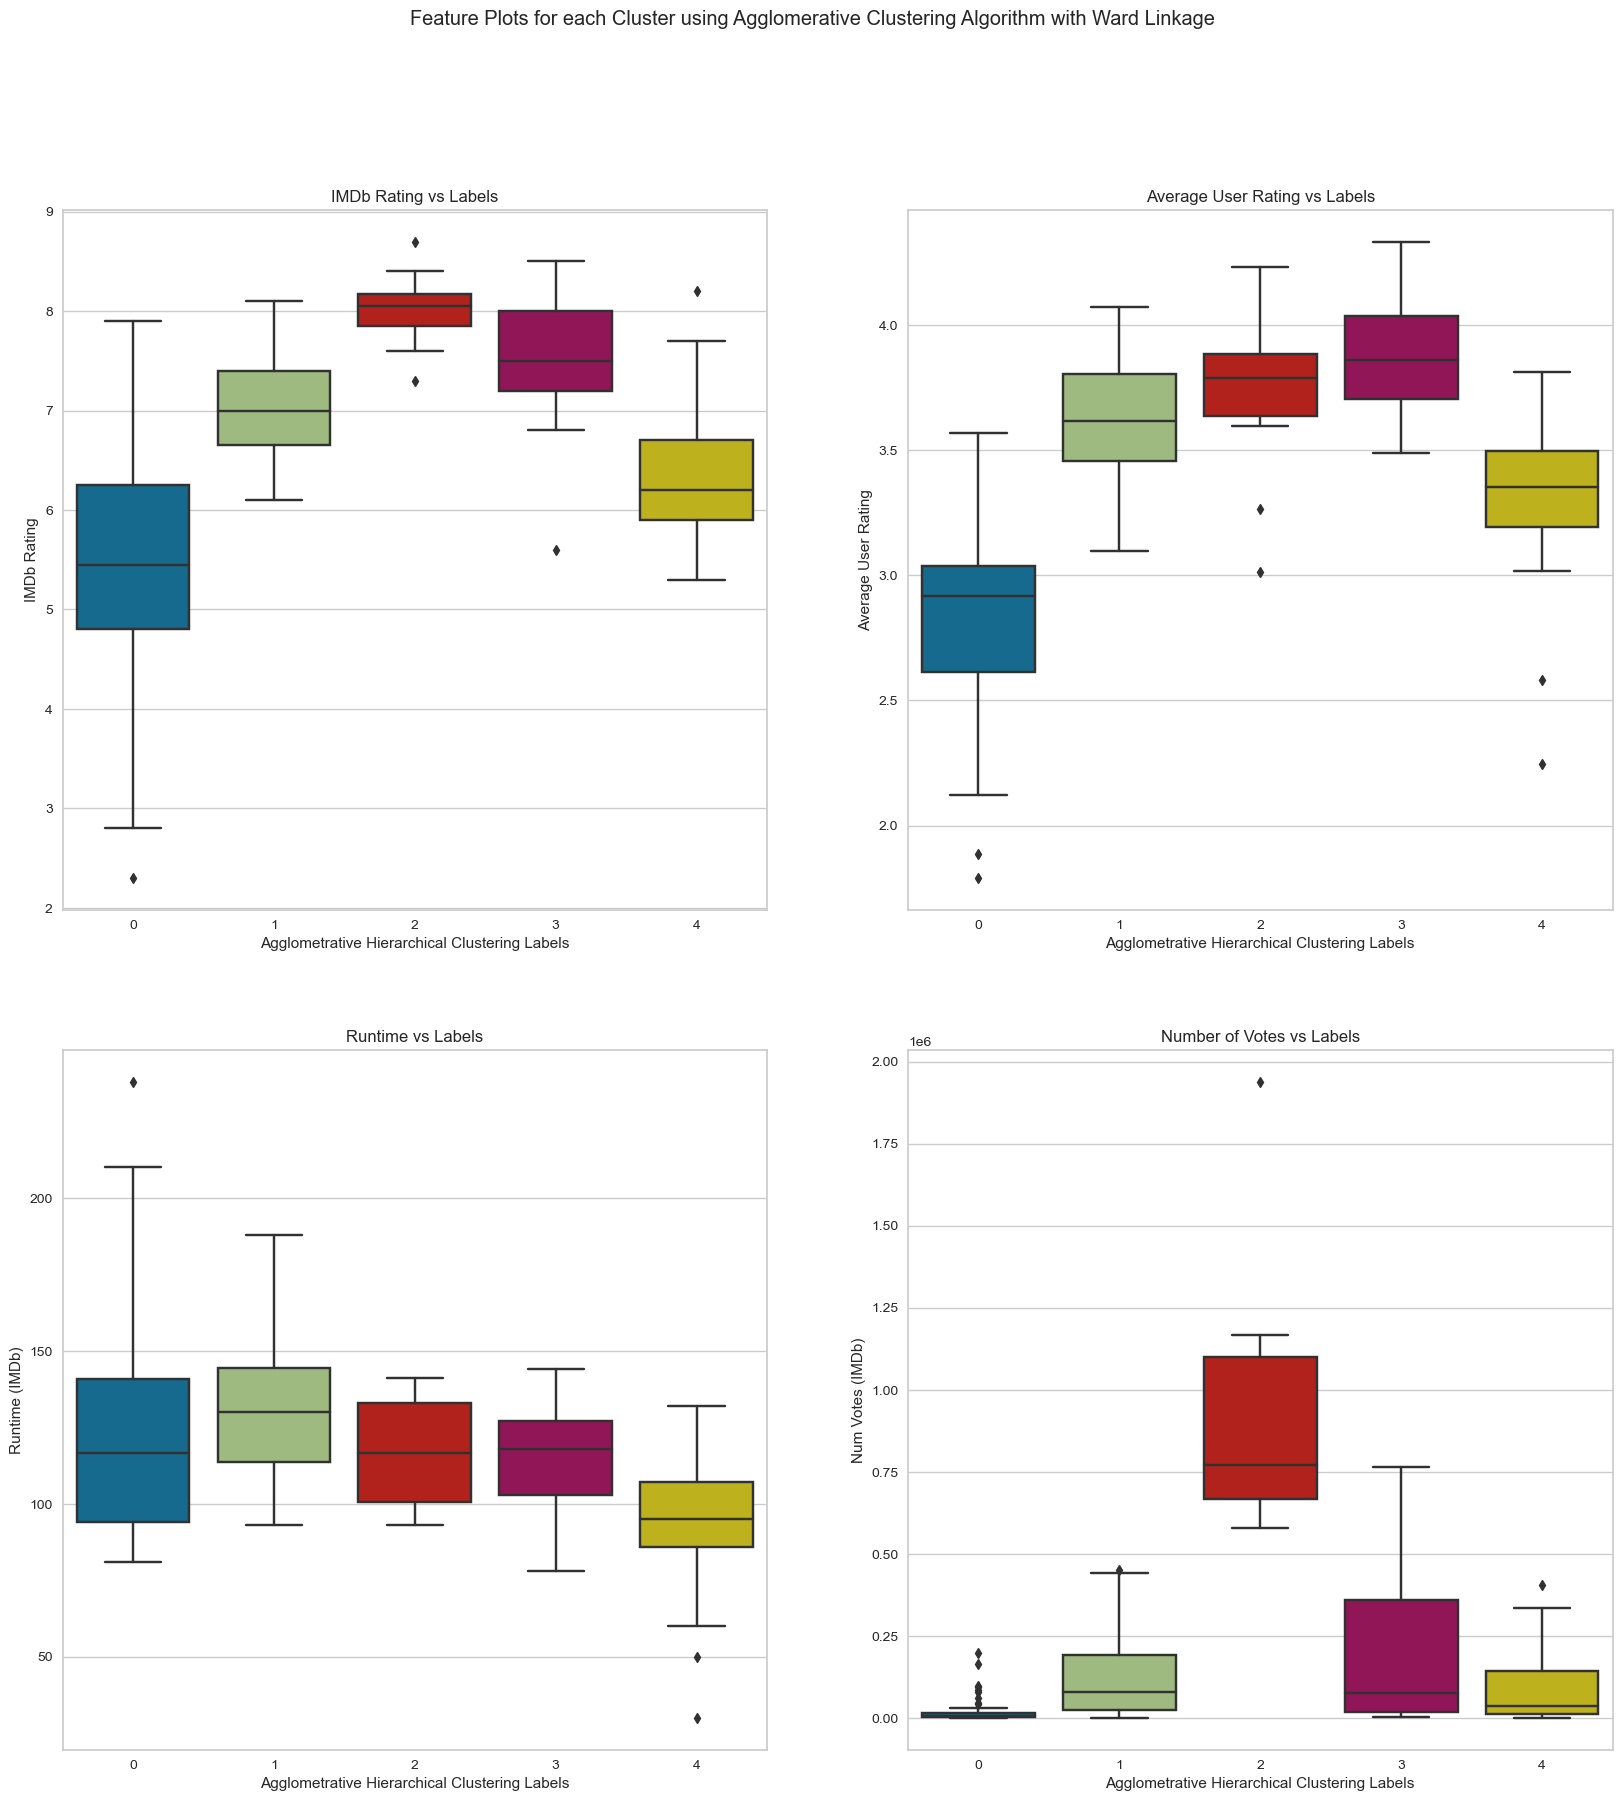

In [26]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

fig.suptitle('Feature Plots for each Cluster using Agglomerative Clustering Algorithm with Ward Linkage')

sns.boxplot(ax = axes[0, 0], data = X_with_predicted_labels, x = X_with_predicted_labels["Agglometrative Hierarchical Clustering Labels"], 
            y = X_with_predicted_labels["IMDb Rating"])
axes[0, 0].set_title("IMDb Rating vs Labels")


sns.boxplot(ax = axes[0, 1], data = X_with_predicted_labels, x = X_with_predicted_labels["Agglometrative Hierarchical Clustering Labels"], 
            y = X_with_predicted_labels["Average User Rating"])
axes[0, 1].set_title("Average User Rating vs Labels")


sns.boxplot(ax = axes[1, 0], data = X_with_predicted_labels, x = X_with_predicted_labels["Agglometrative Hierarchical Clustering Labels"], 
            y = X_with_predicted_labels["Runtime (IMDb)"])
axes[1, 0].set_title("Runtime vs Labels")


sns.boxplot(ax = axes[1, 1], data = X_with_predicted_labels, x = X_with_predicted_labels["Agglometrative Hierarchical Clustering Labels"], 
            y = X_with_predicted_labels["Num Votes (IMDb)"])
axes[1, 1].set_title("Number of Votes vs Labels")


plt.show()

### Findings and Explanations

(1) We see that Cluster 2 becomes our "Highest Priority" cluster in terms of the fact that it generates the Highest Average User Rating. Additionally, we can see that these movies correspond to:


        (a) High IMDb Rating with a Median IMDb of a little above 8 and a very low standard deviation 
        (b) Low Runtime with a Median Runtime of around 130 minutes 
        (c) Very High number of votes - with the highest median - at around 750000
        
        
So, we conclude that even though the clusters are pretty evenly distributed, the number of votes are not as evenly distributed between the clusters - this means that Agglomerative Clustering might not be the best model for our data.

Let us now move in to Gaussian Mixture Modelling have a better idea of our unsupervised clustering. 

## Model 3 - Gaussian Mixture Model

GMM is a probabilistic model that represents data as a mixture of Gaussian Distributions. 

We use a Gaussian Mixture Model because:


(a) GMM assigns a probability to each data point that it belongs to each cluster, rather than assigning hard labels. This is called soft clustering or fuzzy clustering. Soft clustering is useful when the boundaries between clusters are unclear or when a data point may belong to multiple clusters - which might be the case here, given that we have real-world movie data.


(b) GMM is robust to outliers because it models data as a mixture of Gaussian distributions. Outliers are more likely to be assigned to their own cluster or to have a low probability of belonging to any cluster, rather than being assigned to a cluster with other data points.



In [27]:
# Initializing a Gaussian Mixture Model 
gm_model = GaussianMixture()

#Fitting the baseline Model to the data
gm_model.fit(X)


GaussianMixture()

### Tuning the Gaussian Mixture Model 

In [28]:
# Define the parameter grid to search over
param_grid = {
    'n_components': list(range(1, 10)),
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
}

# Define the grid search object
gmm_grid_search = GridSearchCV(gm_model, param_grid=param_grid, cv=5)

# Fit the grid search object to the data
gmm_grid_search.fit(X)

# Print the best hyperparameters found
print("Best hyperparameters:", gmm_grid_search.best_params_)

Best hyperparameters: {'covariance_type': 'diag', 'n_components': 8}


### Obtaining the predictions from the best fit Gaussian Mixture Model 

In [29]:
#Initiatilizing the best fit GMM from GridSearch
gmm_final = gmm_grid_search.best_estimator_

#fitting the model 
gmm_final.fit(X)

#predicting andsaving to the dataset 
X_with_predicted_labels["Gaussian Mixture Model Clustering Labels"] = gmm_final.predict(X)

### Looking at the distributions of different variables across the clusters

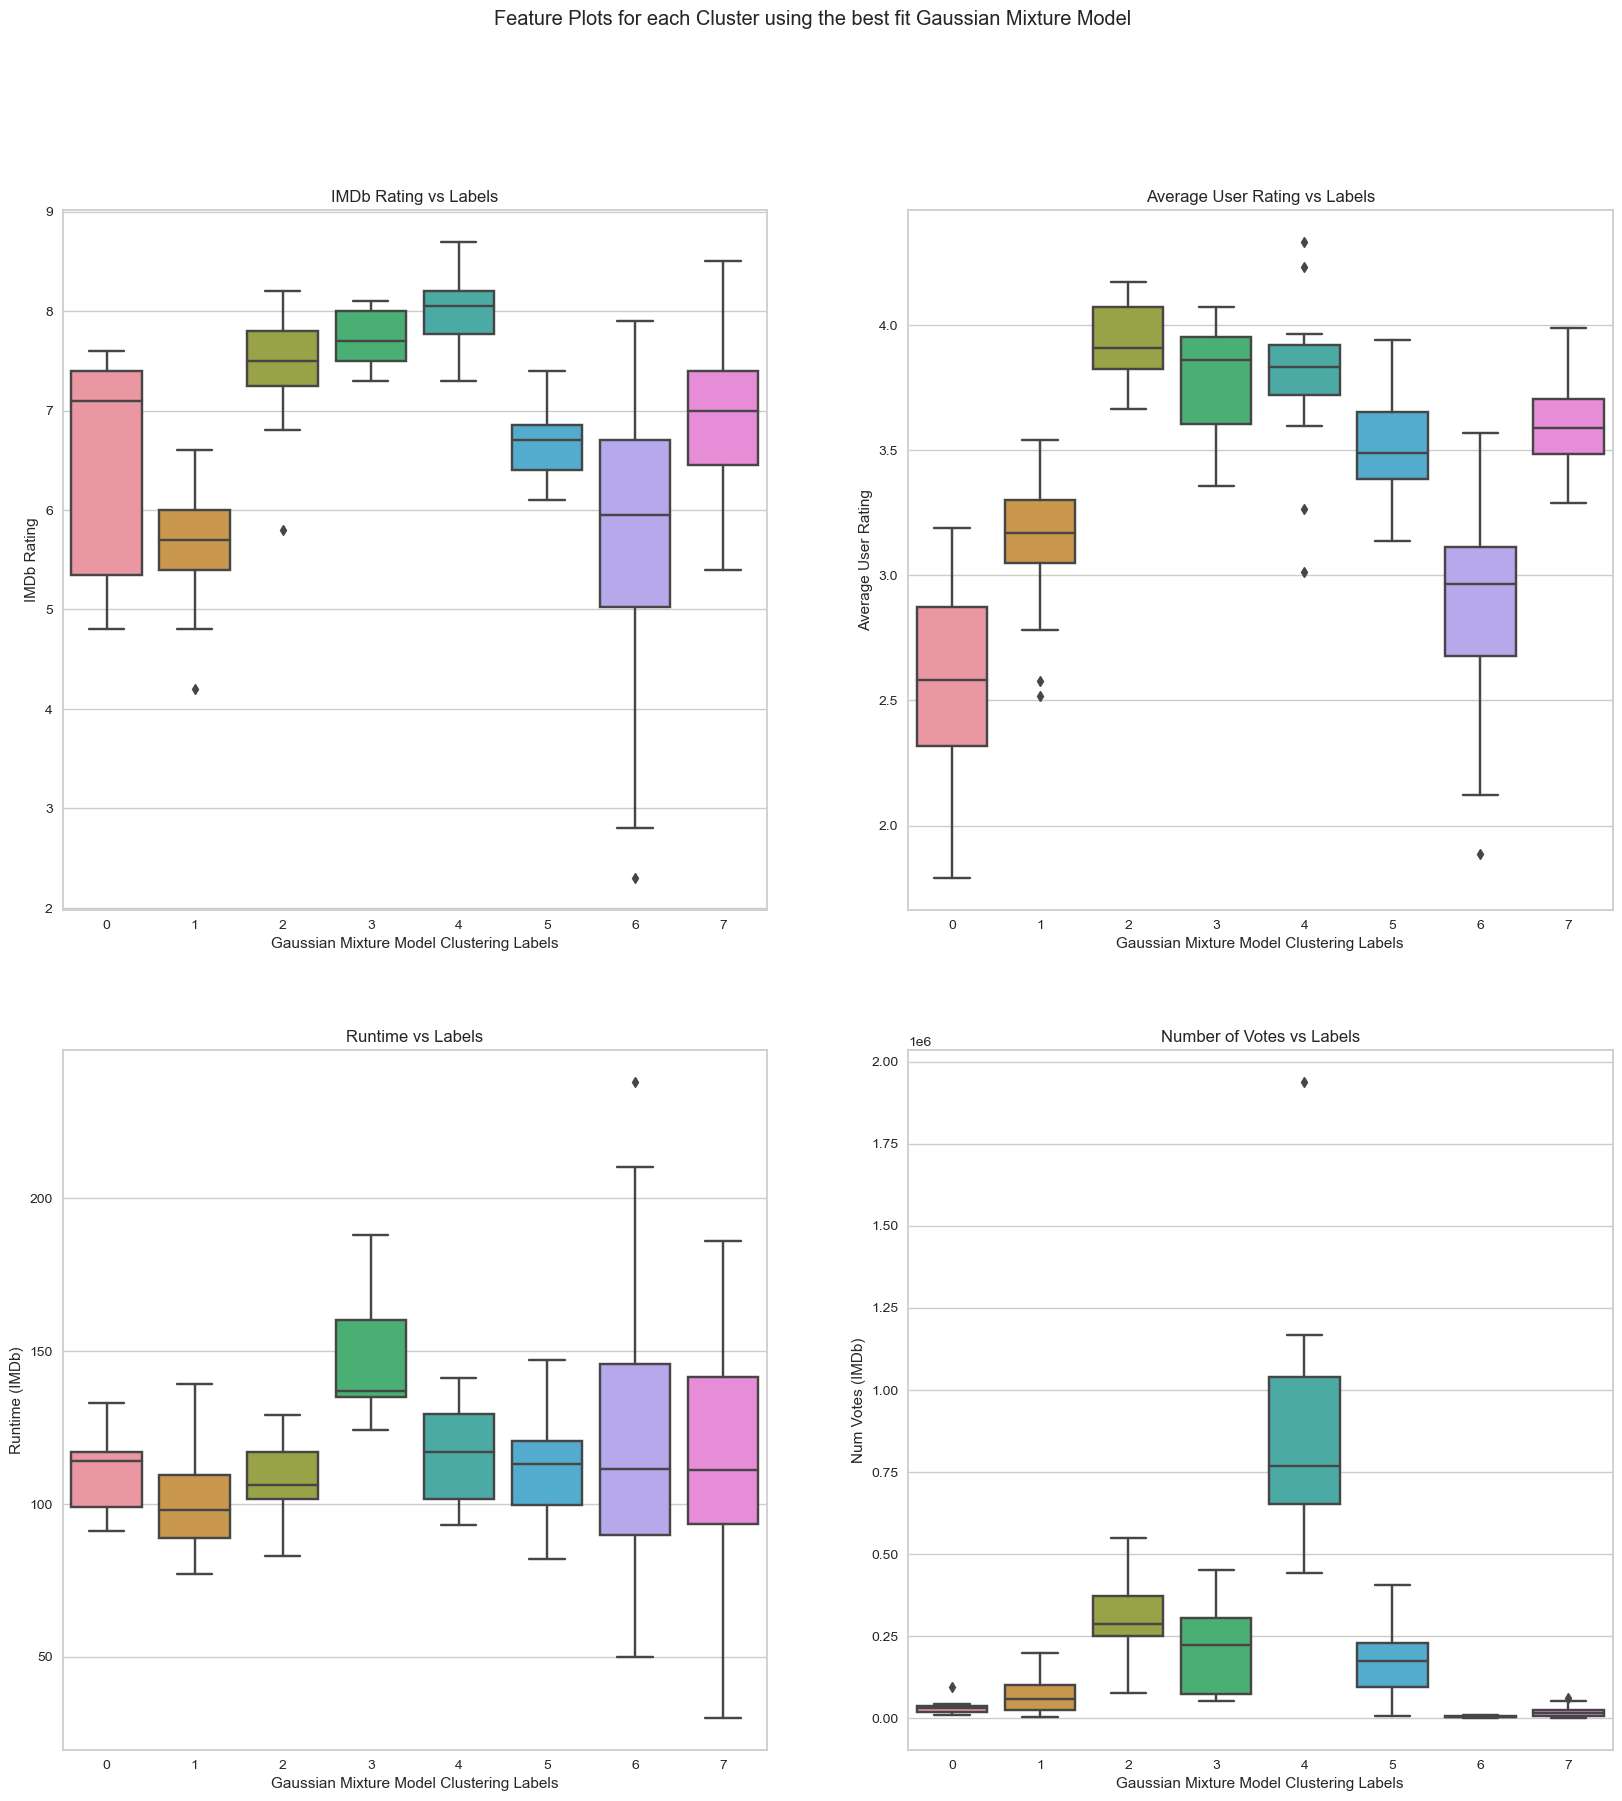

In [30]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

fig.suptitle('Feature Plots for each Cluster using the best fit Gaussian Mixture Model')

sns.boxplot(ax = axes[0, 0], data = X_with_predicted_labels, x = X_with_predicted_labels["Gaussian Mixture Model Clustering Labels"], 
            y = X_with_predicted_labels["IMDb Rating"])
axes[0, 0].set_title("IMDb Rating vs Labels")


sns.boxplot(ax = axes[0, 1], data = X_with_predicted_labels, x = X_with_predicted_labels["Gaussian Mixture Model Clustering Labels"], 
            y = X_with_predicted_labels["Average User Rating"])
axes[0, 1].set_title("Average User Rating vs Labels")


sns.boxplot(ax = axes[1, 0], data = X_with_predicted_labels, x = X_with_predicted_labels["Gaussian Mixture Model Clustering Labels"], 
            y = X_with_predicted_labels["Runtime (IMDb)"])
axes[1, 0].set_title("Runtime vs Labels")


sns.boxplot(ax = axes[1, 1], data = X_with_predicted_labels, x = X_with_predicted_labels["Gaussian Mixture Model Clustering Labels"], 
            y = X_with_predicted_labels["Num Votes (IMDb)"])
axes[1, 1].set_title("Number of Votes vs Labels")


plt.show()

### Findings and Explanations

Among the 8 clusters, we see that clusters 2, 3, 4 have the highest average user ratings.
- Similarly to the results from Hierarchical Clustering, these clusters also correspond to High IMDb ratings.
- However, between clusters 2, 3, 4, while cluster 4 has a median runtime of 120, it is interesting to note that cluster 3 has the highest runtime of all clusters. 
- Also, cluster 4 has a high number of votes while cluster 3 has a much lower number of votes.

## Model 4 - Spectral Clustering Model

We use Spectral Clustering Model because:

(a) Non-linearity: Spectral clustering can handle non-linearly separable clusters, unlike k-means and other traditional clustering methods. Spectral clustering can capture complex and non-linear relationships between data points and is especially useful when clusters have complex shapes.

(b) Scalability: Spectral clustering is computationally efficient and can handle large datasets. It can be used for clustering high-dimensional data and can be easily parallelized.

(c) Robustness to noise: Spectral clustering is robust to noise and can handle outliers in the data. This is because spectral clustering uses the underlying graph structure to find clusters, which is less affected by noise.

Given the non-linear structure of our data, the need for scalability of this system in the future as movie reviews pour in to our dataset, and the inherent noise in any customer facing data repository, we use the Spectral Clustering Model - in hopes that we will have better clustering. 


In [31]:
#initializing a Spectral Clustering Model 
sc_model_baseline = SpectralClustering()

#fitting the baseline model to the data
sc_model_baseline.fit(X)

SpectralClustering()

### Tuning the Spectral Clustering Model 

#### Using the Elbow Score Metric

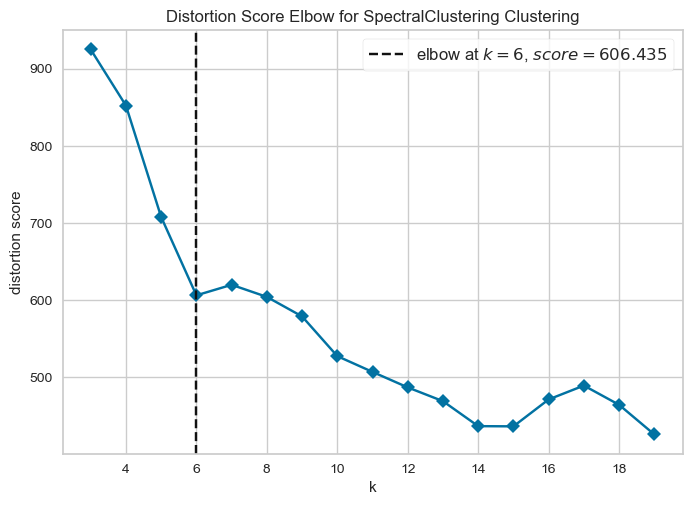

<AxesSubplot:title={'center':'Distortion Score Elbow for SpectralClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
visualizer = KElbowVisualizer(sc_model_baseline, k = (3, 20), timings=False)
visualizer.fit(X)
visualizer.show()

So, according to the Elbow Score metric, the appropriate number of 'K' in our data for a Spectral Clustering Model is 6

#### Using the Calinski-Harabasz Score

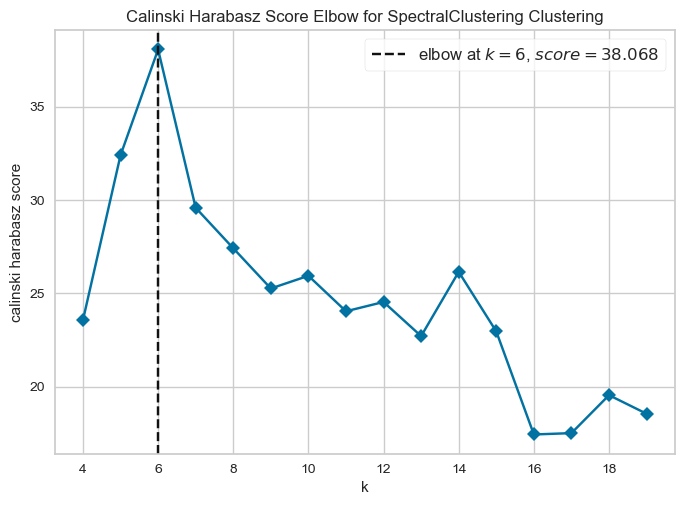

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for SpectralClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [33]:
# using the Calinski Harabasz score to calculate the number of clusters
visualizer = KElbowVisualizer(sc_model_baseline, k = (4, 20), timings=False, locate_elbow=True, metric = "calinski_harabasz")
visualizer.fit(X)
visualizer.show()

So, the best number of clusters according to the Calinkski Harabasz Score is 6. 

#### Using the Silhouette Score Metric

In [34]:
#checking for the K using the Silhouette Score Metric
spectral_clustering_scores = []
for i in range(4, 20):
    #Instantiate the KMeans models
    sc_model = SpectralClustering(n_clusters = i)
    
    # Fit the KMeans model
    sc_model.fit_predict(X)
    
    # Calculate Silhoutte Score
    score = silhouette_score(X, sc_model.labels_, metric='euclidean')
    spectral_clustering_scores.append(score)


#creating a dataframe for storing the Number of Clusters and corresponding Silhouette Score
spectral_clustering_scores_df = pd.DataFrame({"Number of Clusters" : [], "Silhouette Score" : []})
for i in range(4, 20):
    spectral_clustering_scores_df.loc[len(spectral_clustering_scores_df.index)] = [i, spectral_clustering_scores[i-4]]
    

#priting the Silhouette Score Dataframe
spectral_clustering_scores_df

,Number of Clusters,Silhouette Score
0,4.0,0.385908
1,5.0,0.250113
2,6.0,0.253485
3,7.0,0.211222
4,8.0,0.204171
5,9.0,0.180514
6,10.0,0.184456
7,11.0,0.174988
8,12.0,0.164920
9,13.0,0.139726


## Need to substantiate

Now, we know that Silhouette Scores have a range of [-1, 1]. The closer the score is to 1, the better our unsupervised model is. 

This is because higher Silhouette Scores correpond to tight, separated clusters. So, from the above dataframe, we understand that 3 clusters generates the highest possible Silhouette Score (0.41337). 

### Obtaining the Predictions for the Final Spectral Clustering Model

In [35]:
#Initiatilizing the best fit GMM from GridSearch
sc_final = SpectralClustering(n_clusters = 6)

#predicting andsaving to the dataset 
X_with_predicted_labels["Spectral Clustering Model Clustering Labels"] = sc_final.fit_predict(X)

### Distribution of features across the different classes predicted by Spectral Clustering

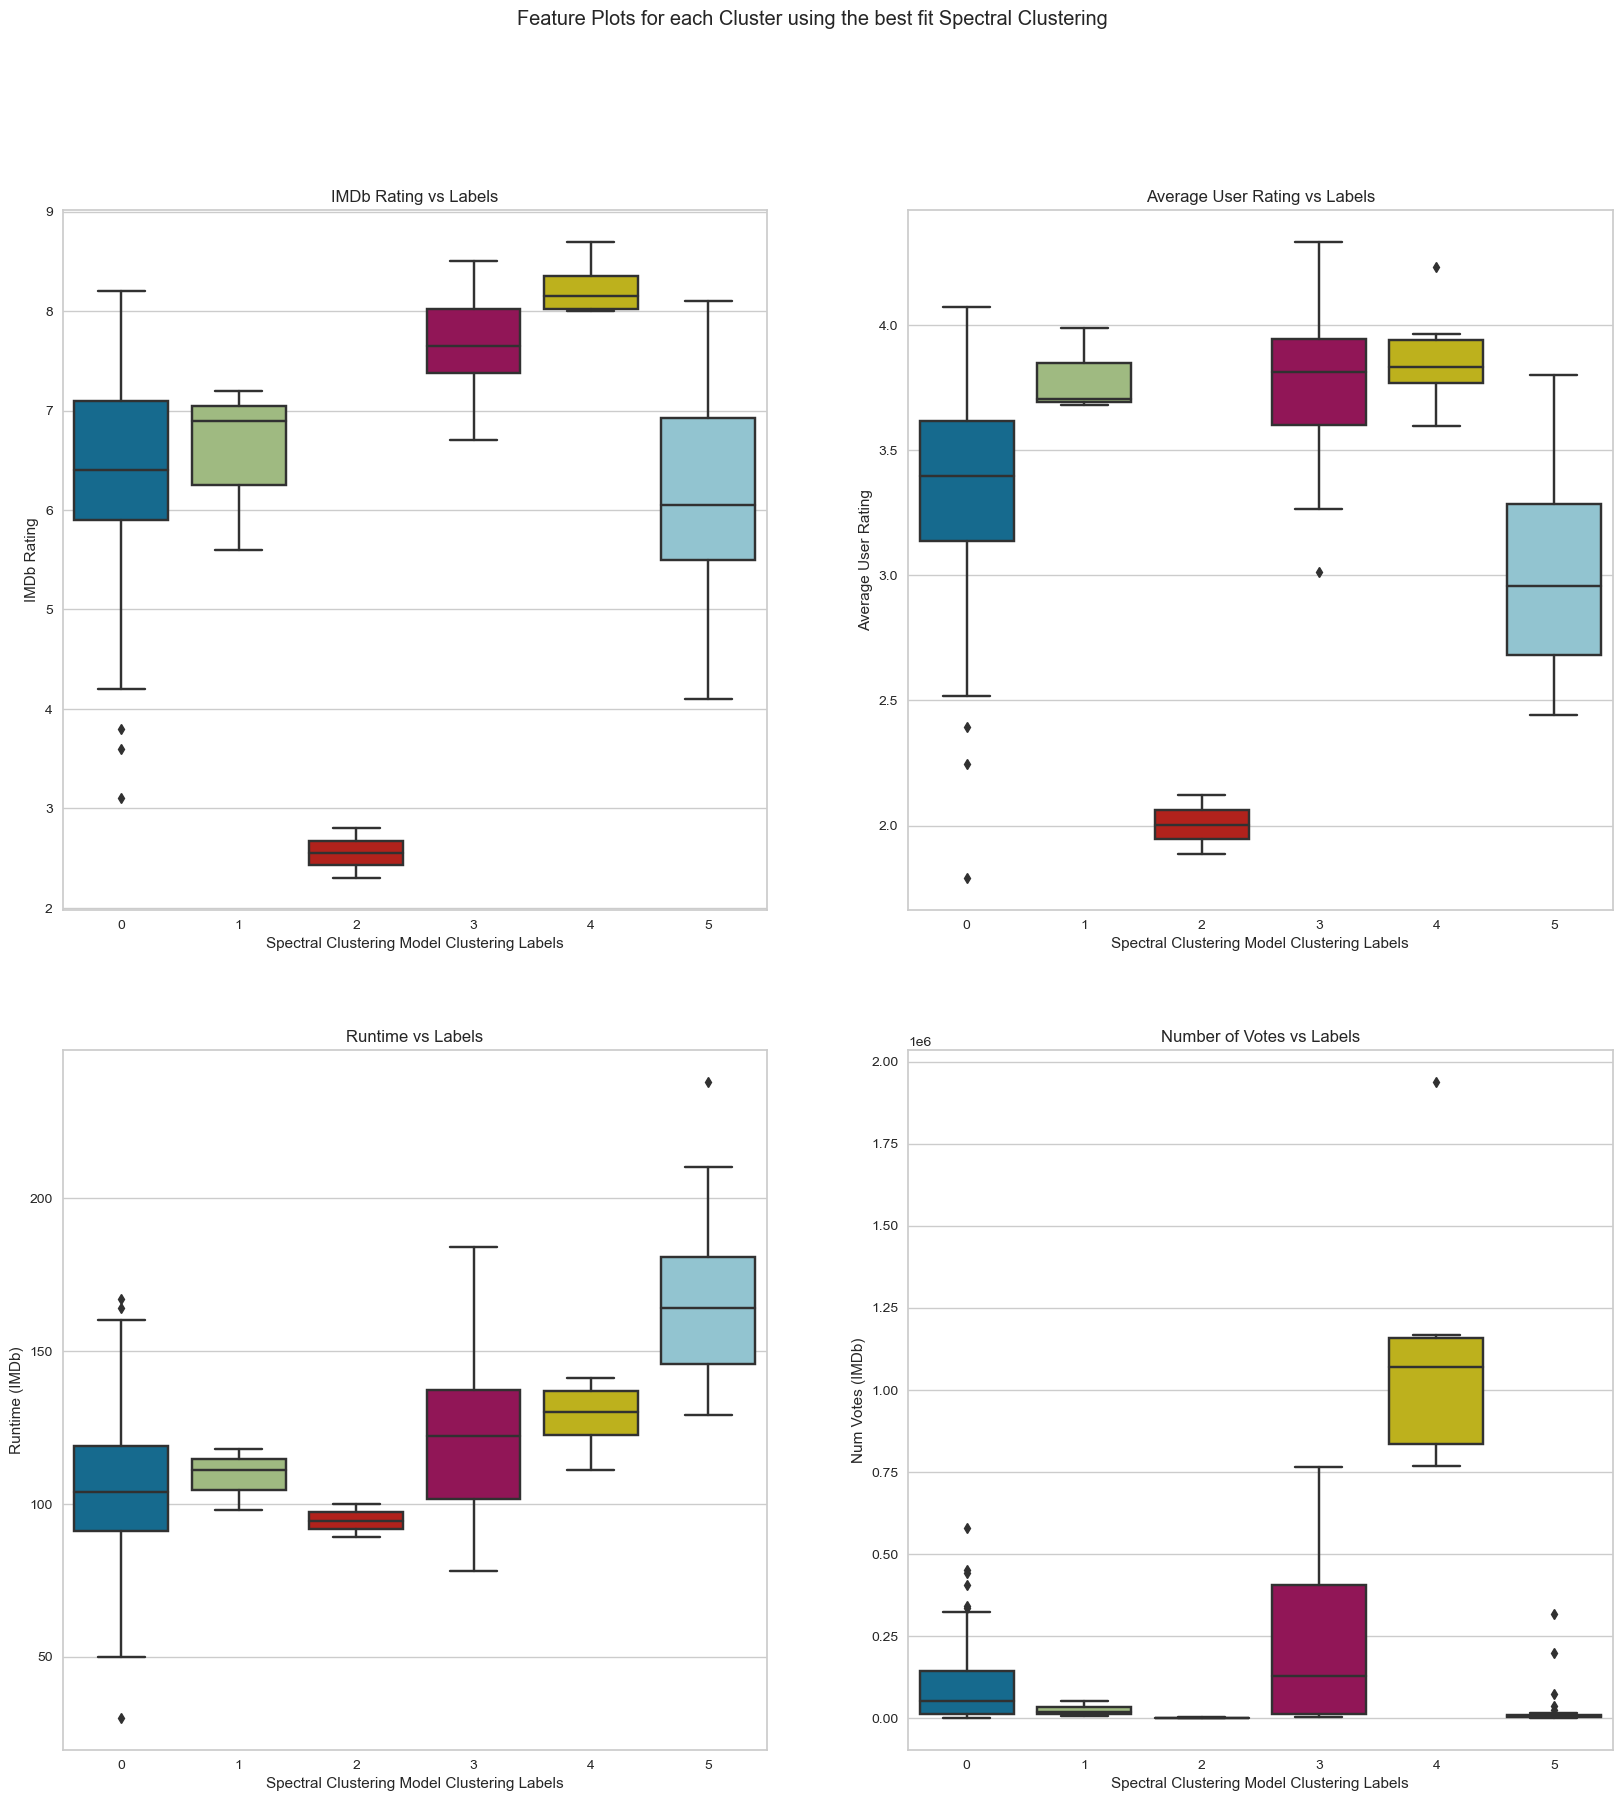

In [36]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

fig.suptitle('Feature Plots for each Cluster using the best fit Spectral Clustering')

sns.boxplot(ax = axes[0, 0], data = X_with_predicted_labels, x = X_with_predicted_labels["Spectral Clustering Model Clustering Labels"], 
            y = X_with_predicted_labels["IMDb Rating"])
axes[0, 0].set_title("IMDb Rating vs Labels")


sns.boxplot(ax = axes[0, 1], data = X_with_predicted_labels, x = X_with_predicted_labels["Spectral Clustering Model Clustering Labels"], 
            y = X_with_predicted_labels["Average User Rating"])
axes[0, 1].set_title("Average User Rating vs Labels")


sns.boxplot(ax = axes[1, 0], data = X_with_predicted_labels, x = X_with_predicted_labels["Spectral Clustering Model Clustering Labels"], 
            y = X_with_predicted_labels["Runtime (IMDb)"])
axes[1, 0].set_title("Runtime vs Labels")


sns.boxplot(ax = axes[1, 1], data = X_with_predicted_labels, x = X_with_predicted_labels["Spectral Clustering Model Clustering Labels"], 
            y = X_with_predicted_labels["Num Votes (IMDb)"])
axes[1, 1].set_title("Number of Votes vs Labels")


plt.show()

### Findings and Explanations
Results of this model are also consistent with the above models in that:
- Highest average user rating: Cluster 4, which corresponds to
    - highest IMDb rating
    - median runtime of 130 minutes
    - highest number of votes
- However, it is interesting to note that cluster 2 has the lowest average user rating, lowest IMDb rating, lowest runtime and lowest number of votes.
- Also, cluster 0 displays a huge variation across all features, which might mean that it is not a tight cluster, and thus clustering the "other" group of the movies.

### Using Principle Component Analysis to Visualize Clusters

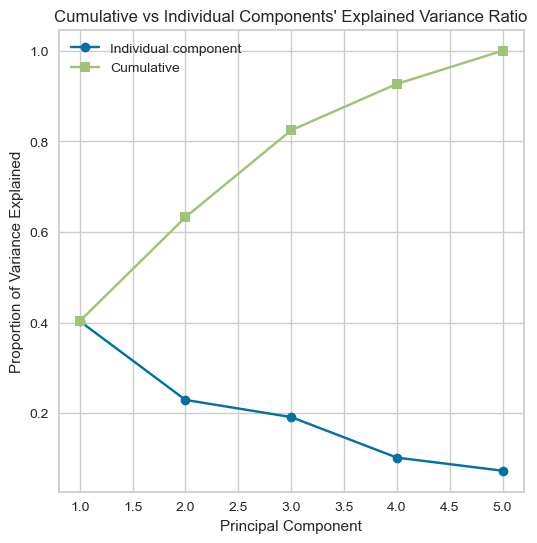

In [37]:
#initializing PCA object
pca = PCA()

# fit on data
pca.fit(X)

#Apply dimensionality reduction to X
X_pca = pca.transform(X)

# pca.n_components_

plt.figure(figsize=(6,6))

x_axis = [*range(1, 6, 1)]
plt.plot(x_axis, pca.explained_variance_ratio_, '-o', 
         label='Individual component')
plt.plot(x_axis, np.cumsum(pca.explained_variance_ratio_), 
         '-s', label='Cumulative')
plt.title("Cumulative vs Individual Components' Explained Variance Ratio")
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.legend(loc=2);

#### Findings and Explanations

(1) From here, we can understand that more than 80% of the variance is the data is being captured by 3 of our Principal Components. 

Additioanlly, our motivation for PCA at this point is to get a visual understanding of our clusters and see which model is perfomrming the best. 

Albeit, visually, we can only plot for 2 features, so we are cognizant of the fact that the clutering might not be perfect in this sense - because we will be capturing around 60% of the variance of our data. 

However, this visual representation will give us a good idea of how our models are performing.

### Plotting the Clusters with the 1st and 2nd Principal Components for all of our Models

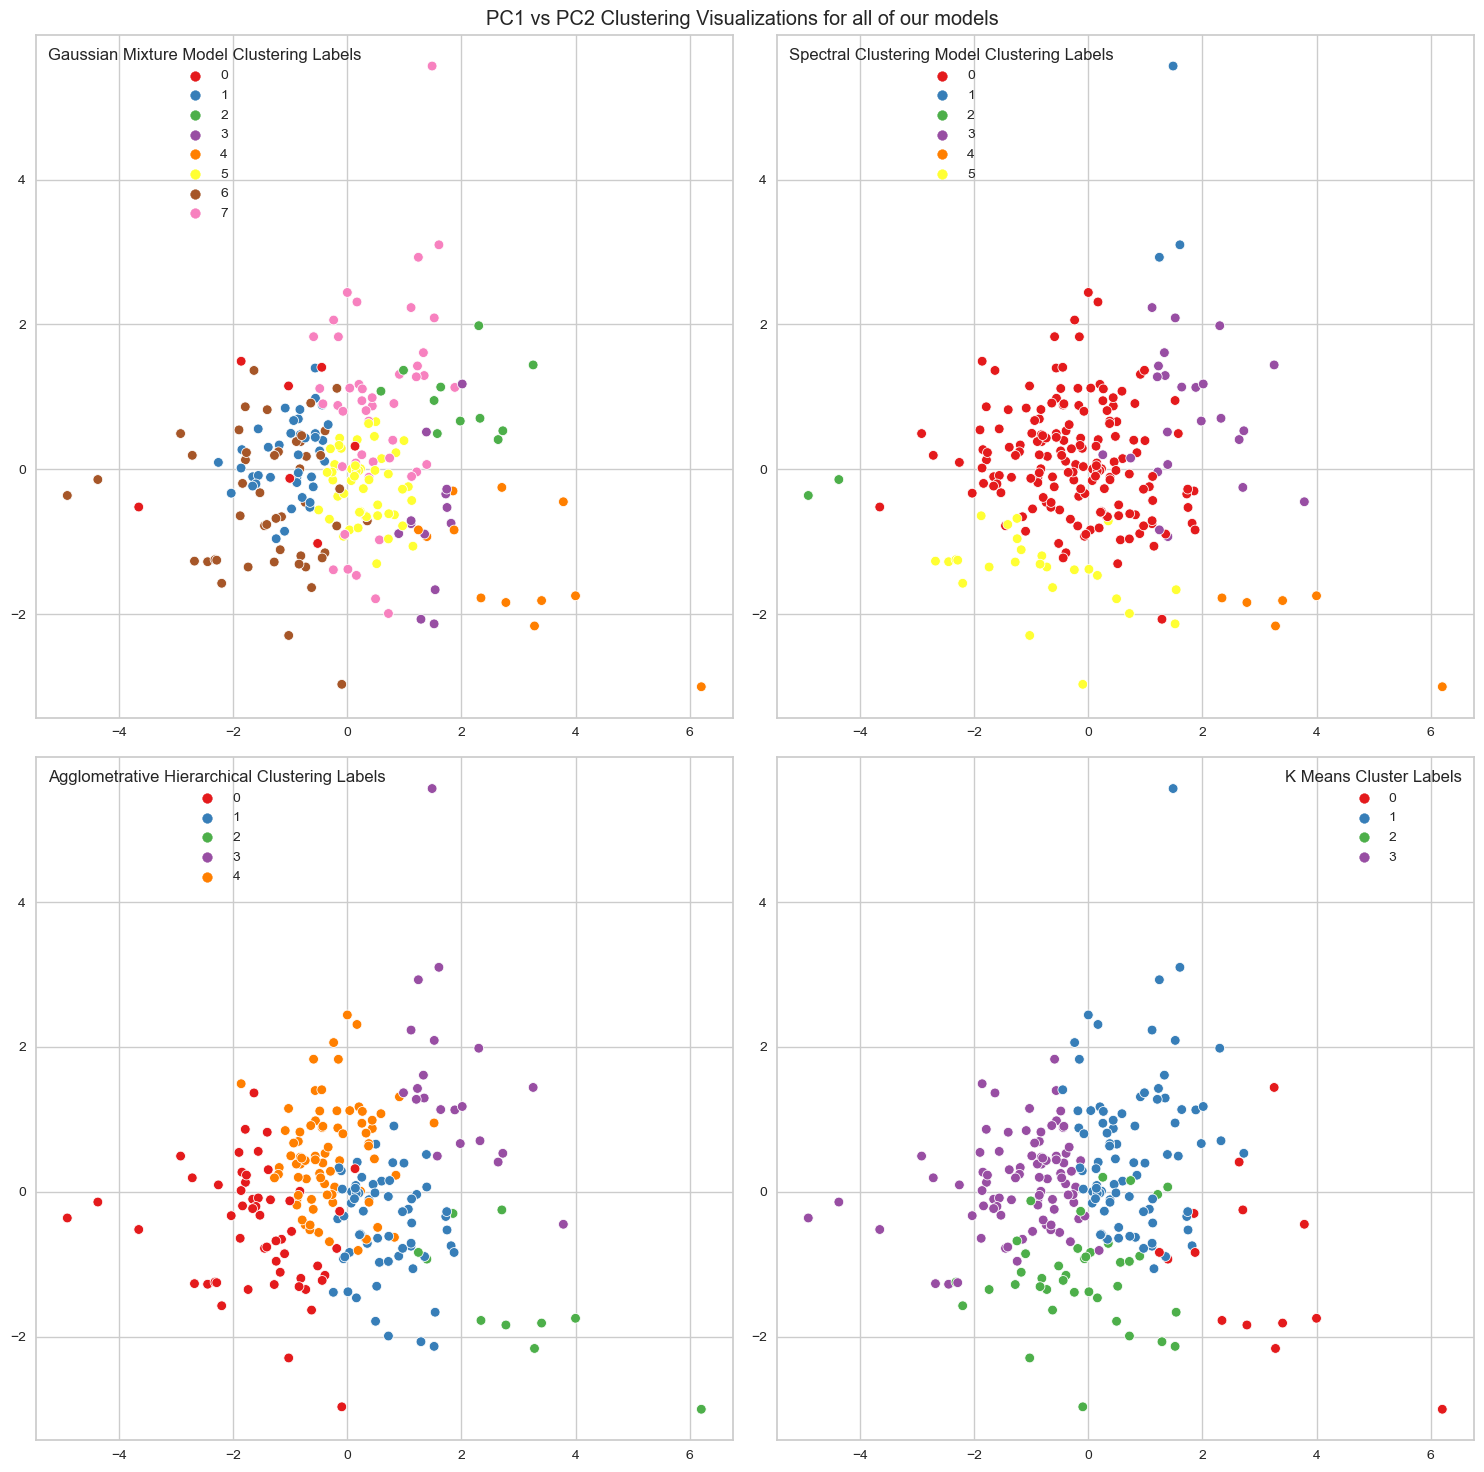

In [38]:
#lets take 3 features - explains a little more than 80% of the total variance in the data 

pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X)

fig, axes = plt.subplots(2, 2, figsize = (15, 15))

fig.suptitle('PC1 vs PC2 Clustering Visualizations for all of our models')

# create scatter plot of PCA components colored by cluster labels for Gaussian Mixture Model 
sns.scatterplot(ax = axes[0,0], x = X_pca[:, 0], y = X_pca[:, 1], hue = X_with_predicted_labels["Gaussian Mixture Model Clustering Labels"], palette='Set1')
sns.scatterplot(ax = axes[0,1], x = X_pca[:, 0], y = X_pca[:, 1], hue = X_with_predicted_labels["Spectral Clustering Model Clustering Labels"], palette='Set1')
sns.scatterplot(ax = axes[1,0], x = X_pca[:, 0], y = X_pca[:, 1], hue = X_with_predicted_labels["Agglometrative Hierarchical Clustering Labels"], palette='Set1')
sns.scatterplot(ax = axes[1,1], x = X_pca[:, 0], y = X_pca[:, 1], hue = X_with_predicted_labels["K Means Cluster Labels"], palette='Set1')

axs[0][0].set(xlabel='PCA Component 1', ylabel='PCA Component 2', title = "Gaussian Mixture Model")
axs[0][1].set(xlabel='PCA Component 1', ylabel='PCA Component 2', title = "Spectral Clustering Model Clustering Labels")
axs[1][0].set(xlabel='PCA Component 1', ylabel='PCA Component 2', title = "Agglometrative Hierarchical Clustering Labels")
axs[1][1].set(xlabel='PCA Component 1', ylabel='PCA Component 2', title = "K Means Cluster Labels")

axs[0][0].legend(loc='lower right')
axs[0][1].legend(loc='lower right')
axs[1][0].legend(loc='lower right')
axs[1][1].legend(loc='lower right')

fig.tight_layout()

plt.show()

## Findings and Explanations

### Final Model Evaluation

From the given scatterplots, we realise that out best models, in order of efficiency of clustering are:

#### (1) K-Means Clustering

(2) Spectral Clustering

(3) Agglomerative Hierarchical Clustering 

(4) Gaussian Mixture Model 

This order is due to the fact that K-Means creates compact clusters, which are interpretable by looking at PC1 and PC2. As we go down the list, the Intercluster distance increases, while the Between Cluster distance decreases - making our clustering less efficient. 


#### Ineffficiency of GMMs 

The inefficiency of GMMs stem from 2 main reasons: 

(1) Unequal variances across clusters: GMMs assume that each cluster has a Gaussian distribution with a specific mean and variance. Since the variances are not equal across the clusters of our movies, this algorithm does not work well.

(2) Non-convex clusters: GMMs assume that the clusters are convex. However, clearly, this is not the case for us, which is another major reason as to the inefficiency of the GMMs. 

### Final Data with Predicted Classes

In [39]:
X_with_predicted_labels

,Title,IMDb Rating,Average User Rating,Runtime (IMDb),Num Votes (IMDb),Year,K Means Cluster Labels,Agglometrative Hierarchical Clustering Labels,Gaussian Mixture Model Clustering Labels,Spectral Clustering Model Clustering Labels
0,A Family Affair,7.1,2.610817,110.0,638.0,2003,3,0,6,0
1,A Night at the Roxbury,6.2,3.137460,82.0,62081.0,1998,3,4,1,0
2,A Wrinkle in Time,4.2,3.375224,109.0,46021.0,2003,3,0,1,0
3,Aitraaz,6.6,3.329787,160.0,10551.0,2004,2,1,7,5
4,Alive and Kicking,6.5,3.044025,94.0,329.0,1996,3,4,6,0
...,...,...,...,...,...,...,...,...,...,...
221,U Turn,7.4,3.104744,120.0,3639.0,1997,2,0,6,0
222,What Lies Beneath,6.6,3.512766,130.0,129615.0,2000,1,1,5,0
223,Wild Wild West,4.9,2.855980,106.0,163212.0,1999,3,0,1,0
224,Willy Wonka & the Chocolate Factory,7.8,4.074219,100.0,207212.0,1971,1,3,2,3


### References 

(1) Lab 10 

(2) https://www.geeksforgeeks.org/ml-hierarchical-clustering-agglomerative-and-divisive-clustering/

(3) https://www.datanovia.com/en/lessons/agglomerative-hierarchical-clustering/

(4) https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad

(5) Homework 1 

(6) Homework 2

(7) Lab 7

(8) https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

(9) https://scikit-learn.org/stable/modules/mixture.html

(10) https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

(11) https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/

(12) Lab 11 

(13) Lab 9 

(14) https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

(15) https://365datascience.com/tutorials/python-tutorials/pca-k-means/

(16) https://pca4ds.github.io/pca-and-clustering.html

